# Testing the effect of thresholds on LCA calls

CMS001_059_Ra_S10 has many wolbachia contigs, plus bloodmeal (passeriformes)

CMS001_003_Ra_S2 has a lot going on, including anaplasma

CMS002_045c_Rb_S185_L004 has wuhan 6

CMS002_053a_Rb_S7_L004 has Wuhan 9

CMS001_040_Ra_S21 This one has Narnavirus and divergent peribunyavirus hits

## Load libraries and define functions

In [ ]:
import pandas as pd
import numpy as np
import boto3
import os
import matplotlib.pyplot as plt
from pylab import rcParams
import pdb
from lca_functions import *

In [ ]:
s3 = boto3.client('s3')
s3_bucket = "czbiohub-mosquito"

In [ ]:
def get_blast_file (sample_names, ntnr):
    blast_fn = [x+"_blast_"+ntnr+".m9" for x in sample_names]
    blast = pd.concat([pd.read_csv(x, comment="#", header=0, sep="\t").assign(sample=sample_names[i]) for i, x in enumerate(blast_fn)])
    blast = blast.assign(qlen=blast["query"].str.split("_").apply(lambda x: int(x[3])))
    blast = blast.assign(identity_qcov=blast["identity"]/100*blast["qcov"])
    if (ntnr=="nr"):
        blast = blast.assign(qcov=blast["qcov"]*3, align_length=blast["align_length"]*3)
    blast["qcov"] = blast["qcov"].apply(lambda x: 1 if x > 1 else x)
    blast = blast.assign(identity_qcov=blast["identity"]/100*blast["qcov"])
    return (blast)

In [ ]:
def keep_only_discordant_taxids (blast):
    multiple_taxids = blast.groupby(["query"]).apply(lambda x: len(x["taxid"].unique()))>1
    queries_to_keep = list(multiple_taxids.index[multiple_taxids])
    return (blast[blast["query"].isin(queries_to_keep)])

In [288]:
def threshold_func1(metrics, threshold, top_hit):
    max_identity_qcov = top_hit["identity_qcov"].iloc[0]
    return (metrics >= max_identity_qcov*threshold)

def threshold_func2(metrics, threshold, top_hit):
    max_identity_qcov = top_hit["identity_qcov"].iloc[0]
    return (metrics >= max_identity_qcov-(1-max_identity_qcov)*threshold)

def threshold_func3(metrics, threshold, top_hit):
    max_identity = top_hit["identity"].iloc[0]/100
    max_qcov = top_hit["qcov"].iloc[0]
    return (metrics >= (max_identity-(1-max_identity)*threshold)*max_qcov)


def test_lca_movement (blast_rows, test_range, threshold_func):
    blast_rows = blast_rows.reset_index()
    max_identity_qcov = blast_rows["identity_qcov"].max()
    best_blast_rows = blast_rows[blast_rows["identity_qcov"]==max_identity_qcov]
    best_lca = get_lca(best_blast_rows)["taxid"].iloc[0]
    best_row = best_blast_rows.head(n=1)
    best_lineage = ncbi.get_lineage(best_lca)
    best_lineage.reverse()
    try:
        row_indices = [str(list(blast_rows.index[threshold_func(blast_rows["identity_qcov"], x, best_row)])) for x in test_range]
    except:
        pdb.set_trace()
    unique_row_indices = list(set(row_indices))
    try:
        unique_lca = [get_lca(blast_rows.iloc[(eval(x))])["taxid"] for x in unique_row_indices]
    except:
        pdb.set_trace()
    unique_lca_movement = [best_lineage.index(int(x)) for x in unique_lca]
    lca_movement = [unique_lca_movement[unique_row_indices.index(x)] for x in row_indices]
    lca = [best_lineage[x] for x in lca_movement]
    lca_movement = [x-min(lca_movement) for x in lca_movement]
    output_df = pd.DataFrame({"sample":[blast_rows["sample"].iloc[0]]*len(test_range),
                              "query":[blast_rows["query"].iloc[0]]*len(test_range),
                              "qlen":[blast_rows["qlen"].iloc[0]]*len(test_range),
                              "best_identity_qcov":[max_identity_qcov]*len(test_range),
#                               "identity_qcov":test_range*best_row["identity_qcov"].iloc[0],
                              "threshold":test_range,
                              "lca_movement":lca_movement,
                              "lca":lca,
                              "row_indices":row_indices
                             }
                            )
    return (output_df)
    

In [181]:
def remove_hexapoda (lca):
    test = lca.groupby(["sample", "query"]).apply(lambda x: x["lca"].apply(lambda y: 6960 in ncbi.get_lineage(y)).any()).reset_index(name="exclude")
    output = pd.merge(test[~test["exclude"]].drop(columns="exclude"), lca, how="left", on=["sample", "query"])
    return (output)

In [ ]:
def plot_lca_movement(df, ax, xlabel=None, ylabel=None, title=None):
    df.groupby(["sample", "query"]).apply(lambda x: ax.plot(x["identity_qcov_prop"], x["lca_movement"]))
    if (xlabel is not None):
        ax.set_xlabel(xlabel)
    if (ylabel is not None):
        ax.set_ylabel(ylabel)
    if (title is not None):
        ax.set_title(title)



In [ ]:
def plot_by_max_metric(df, ntnr, figwidth=10, figheight=10):
    rcParams['figure.figsize'] = figwidth, figheight
    fig = plt.figure()
    metric_range = [0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95]
    fig, axs = plt.subplots(len(metric_range), 1)
    for i, qlen in enumerate(metric_range):
        metric_list = df["identity_qcov"]
        lower = metric_range[i]
        try:
            upper = qlen_limits[i+1]
            subdf = df[(metric_list > lower) & (metric_list <= upper)]
        except:
            subdf = df[metric_list > lower]
        plot_title = ntnr+": max identity_qcov between "+str(lower)+" and "+str(upper)
        if (i==len(metric_range)):
            plot_lca_movement(subdf, axs[i], 
                              xlabel="Proportion of max(identity_qcov)",
                              title=plot_title
                             )
        elif(i==int(len(qlen_limits)/2)):
            plot_lca_movement(subdf, axs[i],
                              ylabel="Increase in taxonomic level relative to species",
                              title=plot_title
                             )
        else:
            plot_lca_movement(subdf, axs[i],
                              title=plot_title
                             )
        axs[i].set_xlim([df["identity_qcov_prop"].min(), 1])
        axs[i].set_ylim([df["lca_movement"].min(), df["lca_movement"].max()])


## Analysis

In [ ]:
test_samples = ["CMS001_059_Ra_S10", "CMS001_003_Ra_S2", "CMS002_045c_Rb_S185_L004", "CMS002_053a_Rb_S7_L004", "CMS001_040_Ra_S21"]
[print("parallel python lca_analysis2.py --blast_type "+ntnr+" --fpath s3://czbiohub-mosquito/contigs/{}/blast_"+ntnr+".m9 --outpath {}_blast_"+ntnr+".m9 --verbose True ::: "+' '.join(test_samples)) for  ntnr in ["nt", "nr"]]

In [ ]:
%%bash
#parallel python lca_analysis2.py --blast_type nt --fpath s3://czbiohub-mosquito/contigs/{}/blast_nt.m9 --outpath {}_blastnt.m9 --verbose True ::: CMS001_059_Ra_S10 CMS001_003_Ra_S2 CMS002_045c_Rb_S185_L004 CMS002_053a_Rb_S7_L004 CMS001_040_Ra_S21
#parallel python lca_analysis2.py --blast_type nr --fpath s3://czbiohub-mosquito/contigs/{}/blast_nr.m9 --outpath {}_blastnr.m9 --verbose True ::: CMS001_059_Ra_S10 CMS001_003_Ra_S2 CMS002_045c_Rb_S185_L004 CMS002_053a_Rb_S7_L004 CMS001_040_Ra_S21

Import blast_nt/nr_filtered.m9 files from the contig_quality folders:

In [ ]:
blast_nt = get_blast_file(test_samples, "nt")
#blast_nr = get_blast_file(test_samples, "nr")

Keep only the queries for which there are discordant blast hits with regards to taxid calls

In [ ]:
blast_nt_multiples = keep_only_discordant_taxids(blast_nt)
blast_nr_multiples = keep_only_discordant_taxids(blast_nr)

Using the identity x query coverage (identity_qcov) metric, keep only blast hits with identity_qcov >= threshold x max(identity_qcov) for that query. Compute the LCA based on these blast hits. Evaluate for different thresholds between 0.8-1 to see how much the LCA result changes with different thresholds.

In [289]:
threshold_functions = [threshold_func1, threshold_func2, threshold_func3]
threshold_test_range = [np.linspace(1, 0.8, 21), np.linspace(0, 1, 11), np.linspace(0, 1, 11)]


In [ ]:
blast_nt_lca_movement = [blast_nt_multiples.groupby("query", as_index=False).apply(test_lca_movement, test_range = threshold_test_range[i], threshold_func=func) for i, func in enumerate(threshold_functions)]

In [290]:
blast_nt_lca_movement_nohex = [remove_hexapoda(x) for x in blast_nt_lca_movement]

In [291]:
blast_nr_lca_movement = [blast_nr_multiples.groupby("query", as_index=False).apply(test_lca_movement, test_range = threshold_test_range[i], threshold_func=func) for i, func in enumerate(threshold_functions)]

In [292]:
blast_nr_lca_movement_nohex = [remove_hexapoda(x) for x in blast_nr_lca_movement]

In [218]:
lca_movements_nt = pd.concat([x.groupby(["sample", "query"])["lca_movement"].max() for x in blast_nt_lca_movement_nohex], axis=1).reset_index()
lca_movements_nt[lca_movements_nt.iloc[:, range(2, len(threshold_functions)+2)].apply(lambda x: ~(x==0).all(), axis=1)]
lca_movements_nt[lca_movements_nt.iloc[:, 2]>lca_movements_nt.iloc[:, 4]*2]

,sample,query,lca_movement,lca_movement,lca_movement
1,CMS001_003_Ra_S2,NODE_10099_length_268_cov_0.963351,27,3,3
4,CMS001_003_Ra_S2,NODE_10161_length_268_cov_0.764398,30,0,0
7,CMS001_003_Ra_S2,NODE_10287_length_267_cov_0.768421,30,0,0
12,CMS001_003_Ra_S2,NODE_10425_length_266_cov_0.772487,9,0,0
13,CMS001_003_Ra_S2,NODE_10501_length_265_cov_1.058511,30,0,0
...,...,...,...,...,...
922,CMS002_053a_Rb_S7_L004,NODE_8326_length_402_cov_1.987692,7,7,0
924,CMS002_053a_Rb_S7_L004,NODE_932_length_1032_cov_2.941361,29,33,0
926,CMS002_053a_Rb_S7_L004,NODE_9840_length_376_cov_1.274247,9,9,0
927,CMS002_053a_Rb_S7_L004,NODE_9948_length_374_cov_69.491582,4,4,0


In [293]:
lca_movements_nr = pd.concat([x.groupby(["sample", "query"])["lca_movement"].max() for x in blast_nr_lca_movement_nohex], axis=1).reset_index()
lca_movements_nr[lca_movements_nr.iloc[:, range(2, len(threshold_functions)+2)].apply(lambda x: ~(x==0).all(), axis=1)]
lca_movements_nr[lca_movements_nr.iloc[:, 2]>lca_movements_nr.iloc[:, 4]*2]

,sample,query,lca_movement,lca_movement,lca_movement
0,CMS001_003_Ra_S2,NODE_10899_length_262_cov_1.183784,20,20,0
1,CMS001_003_Ra_S2,NODE_11201_length_260_cov_3.191257,10,10,0
2,CMS001_003_Ra_S2,NODE_11215_length_260_cov_1.595628,25,24,0
3,CMS001_003_Ra_S2,NODE_11659_length_257_cov_2.027778,18,18,0
4,CMS001_003_Ra_S2,NODE_1248_length_631_cov_80.900722,13,13,0
5,CMS001_003_Ra_S2,NODE_14725_length_239_cov_2.246914,9,3,3
6,CMS001_003_Ra_S2,NODE_1860_length_537_cov_119.678261,23,23,0
7,CMS001_003_Ra_S2,NODE_2588_length_472_cov_1.683544,4,4,0
9,CMS001_003_Ra_S2,NODE_3530_length_417_cov_1.488235,10,10,0
14,CMS001_003_Ra_S2,NODE_5110_length_358_cov_0.686833,7,2,2


In [294]:
def return_change_point(lca_movements):
    if (lca_movements[-1]==lca_movements[0]):
        return (len(lca_movements)-1)
    for i, x in enumerate(lca_movements):
        if (x>lca_movements[0]):
            break
    return (i)

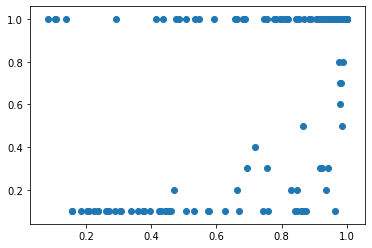

In [295]:
#plt.hist(blast_nr_lca_movement_nohex[1].groupby(["sample", "query"]).apply(lambda x: x["threshold"].iloc[int(return_change_point(x["lca_movement"].tolist()))]).reset_index()[0])
#plt.hist(blast_nr_lca_movement_nohex[1]["qlen"])
plt.scatter(blast_nr_lca_movement_nohex[1].groupby(["sample", "query"])["best_identity_qcov"].first(), blast_nr_lca_movement_nohex[1].groupby(["sample", "query"]).apply(lambda x: x["threshold"].iloc[int(return_change_point(x["lca_movement"].tolist()))]).reset_index()[0])

In [257]:
test_sample_name = "CMS001_003_Ra_S2"
test_contig_name = "NODE_9941_length_269_cov_1.520833"

In [258]:
blast_nr_multiples[(blast_nr_multiples["sample"]==test_sample_name) & (blast_nr_multiples["query"]==test_contig_name)]

,query,subject,identity,align_length,mismatches,gaps,qstart,qend,sstart,send,...,taxid,sci_name,common_name,subject_title,qcov,hsp_count,blast_type,sample,qlen,identity_qcov
11343,NODE_9941_length_269_cov_1.520833,gi|20138428|sp|HBA1_BUBBU|Q9TSN7.3|,91.01,267,8,0,2,268,52,140,...,89462,Bubalus bubalis,water buffalo,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.903333
11344,NODE_9941_length_269_cov_1.520833,gi|110831902|sp|HBA_ALCAA|P01971.2|,96.63,267,3,0,2,268,52,140,...,9853,Alces alces alces,european elk,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.959116
11345,NODE_9941_length_269_cov_1.520833,gi|115502221|sp|HBA_PANHO|Q0ZA50.3|,93.26,267,6,0,2,268,52,140,...,59538,Pantholops hodgsonii,chiru,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.925666
11346,NODE_9941_length_269_cov_1.520833,gi|110831923|sp|HBA_BOSGF|P01969.2|,92.13,267,7,0,2,268,52,140,...,30520,Bos frontalis,gayal,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.914450
11347,NODE_9941_length_269_cov_1.520833,gi|110831922|sp|HBA_BISBO|P09423.2|,92.13,267,7,0,2,268,52,140,...,9902,Bison bonasus,European bison,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.914450
11348,NODE_9941_length_269_cov_1.520833,gi|195927257|pdb|2QU0|65|||2008|8|1|,94.38,267,5,0,2,268,51,139,...,9940,Ovis aries,sheep,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.936783
11349,NODE_9941_length_269_cov_1.520833,gi|1187605762|ref|XP_020755840.1|,98.88,267,1,0,2,268,52,140,...,9880,Odocoileus virginianus texanus,NaN,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.981448
11350,NODE_9941_length_269_cov_1.520833,gi|803279815|ref|XP_011999574.1|,95.51,267,4,0,2,268,52,140,...,9938,Ovis aries musimon,mouflon,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.947999
11351,NODE_9941_length_269_cov_1.520833,gi|1789|embl|CAA49750.1|,95.51,267,4,0,2,268,52,140,...,9940,Ovis aries,sheep,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.947999
11352,NODE_9941_length_269_cov_1.520833,gi|803279817|ref|XP_011999575.1|,94.38,267,5,0,2,268,52,140,...,9938,Ovis aries musimon,mouflon,NaN,0.992565,1,nr,CMS001_003_Ra_S2,269,0.936783


In [259]:
blast_nr_lca_movement_nohex[1][(blast_nr_lca_movement_nohex[1]["sample"]==test_sample_name) & (blast_nr_lca_movement_nohex[1]["query"]==test_contig_name)]

,sample,query,qlen,threshold,lca_movement,lca,row_indices
253,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.0,0,9880,"[6, 12]"
254,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.1,0,9880,"[6, 12]"
255,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.2,0,9880,"[6, 12]"
256,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.3,0,9880,"[6, 12]"
257,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.4,0,9880,"[6, 12]"
258,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.5,0,9880,"[6, 12]"
259,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.6,0,9880,"[6, 12]"
260,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.7,3,9881,"[6, 12, 17]"
261,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.8,3,9881,"[6, 12, 17]"
262,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.9,3,9881,"[6, 12, 17]"


In [260]:
blast_nr_lca_movement_nohex[2][(blast_nr_lca_movement_nohex[2]["sample"]==test_sample_name) & (blast_nr_lca_movement_nohex[2]["query"]==test_contig_name)]

,sample,query,qlen,threshold,lca_movement,lca,row_indices
253,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.0,0,9880,"[6, 12]"
254,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.1,0,9880,"[6, 12]"
255,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.2,0,9880,"[6, 12]"
256,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.3,0,9880,"[6, 12]"
257,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.4,0,9880,"[6, 12]"
258,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.5,0,9880,"[6, 12]"
259,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.6,0,9880,"[6, 12]"
260,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.7,0,9880,"[6, 12]"
261,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.8,0,9880,"[6, 12]"
262,CMS001_003_Ra_S2,NODE_9941_length_269_cov_1.520833,269,0.9,0,9880,"[6, 12]"


In [ ]:
fig, ax = plt.subplots()
ax.scatter(blast_nt_multiples.groupby(["query"]).apply(lambda x: x["identity_qcov"].max()),
        blast_nt_multiples.groupby(["query"]).apply(lambda x: x["qlen"].max()))


In [ ]:
rcParams['figure.figsize'] = 10, 4
plt.hist(blast_nt_multiples.groupby("query").apply(lambda x: x["identity_qcov"].max()))


In [ ]:
rcParams['figure.figsize'] = 10, 4
plt.hist(blast_nr_multiples.groupby("query").apply(lambda x: x["identity_qcov"].max()), density=True)

In [ ]:
blast_nt_multiples.groupby("query").apply(lambda x: [x["identity_qcov"].max(), x["identity_qcov"].min()])

## Results

For each query, plot the changes in LCA level with respect to changes in thresholds.

In [ ]:
plot_by_max_metric(blast_nt_lca_movement, ntnr="nt", figwidth=15, figheight=25)


In [ ]:
plot_by_max_metric(blast_nr_lca_movement, ntnr="nr", figwidth=15, figheight=25)

The LCA moves up the tree as the threshold for keeping blast hits becomes more relaxed. The rate at which the LCA moves up the tree increases with decreasing value of max(identity x query coverage). 